In [ ]:
%matplotlib inline

The first part of assignment list is based on the examples provided in an excelent course by Roger R. Labbe Jr "Kalman and Bayesian Filters in Python"

## Newton's Equations of Motion

Newton's equations of motion tells us that given a constant velocity $v$ of a system we can compute its position $x$ after time $t$ with:

$$x = vt + x_0$$

For example, if we start at position 13, our velocity is 10 m/s, and we travel for 12 seconds our final position is 133 ($10\times 12 + 13$).

We can incorporate constant acceleration with this equation

$$x = \frac{1}{2}at^2 + v_0t + x_0$$

And if we assume constant jerk we get

$$x = \frac{1}{6}jt^3 +  \frac{1}{2}a_0 t^2 + v_0 t + x_0$$

These equations were generated by integrating a differential equation. Given a constant velocity v we can compute the distance traveled over time with the equation

$$x = vt + x_0$$

which we can derive with

$$\begin{aligned} v &= \frac{dx}{dt}\\
dx &= v\, dt \\
\int_{x_0}^x\, dx &= \int_0^t v\, dt\\
x - x_0 &= vt - 0\\
x &= vt + x_0\end{aligned}$$


When you design a Kalman filter you start with a system of differential equations that describe the dynamics of the system. Most systems of differential equations do not easily integrate in this way. We start with Newton's equation because we can integrate and get a closed form solution, which makes the Kalman filter easier to design. An added benefit is that Newton's equations are the right equations to use to track moving objects, one of the main uses of Kalman filters.

## Tracking a Dog

We start by writing a simulation for the dog. The simulation will run for `count` steps, moving the dog forward approximately 1 meter for each step. At each step the velocity will vary according to the process variance `process_var`. After updating the position we compute a measurement with an assumed sensor variance of `z_var`. The function returns an NumPy array of the positions and another of the measurements.

In [ ]:
import math
import numpy as np
from numpy.random import randn

def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## Predict Step

For the prediction we need to design the state and covariance, the process model and the process noise, and optionally the control input. We'll take them in order.

### Design State Variable

We can track a dog in one dimension by using a Gaussian. The mean $(\mu)$ represents the most likely position, and the variance ($\sigma^2$) represented the probability distribution of the position. The position is the *state* of the system, and we call $\mu$ the *state variable*. 

In this problem we will be tracking both the position and velocity of the dog. This requires us to use a multivariate Gaussian represented with the state vector $\mathbf x$ and its corresponding covariance matrix $\mathbf P$. 

State variables can either be *observed variables* - directly measured by a sensor, or *hidden variables* - inferred from the observed variables. For our dog tracking problem the sensor only reads position, so position is observed and velocity is hidden. We will learn how to track hidden variables soon.

It is important to understand that tracking position and velocity is a design choice with implications and assumptions that we are not yet prepared to explore. For example, we could also track acceleration, or even jerk. For now, recall that in the last chapter we showed that including velocity in the covariance matrix resulted in much smaller variances in position. We will learn how the Kalman filter computes estimates for hidden variables later in this chapter. 

In the univariate case we can represent the dog's position with a scalar value (e.g. $\mu=3.27$). In the multivariate case, if we wanted to specify a position of 10.0 m and a velocity of 4.5 m/s, we would write:

$$\mu = \begin{bmatrix}10.0\\4.5\end{bmatrix}$$

The Kalman filter is implemented using linear algebra. We use an $n\times 1$ matrix (called a *vector*) to store  $n$ state variables. For the dog tracking problem, we use $x$ to denote position, and the first derivative of $x$, $\dot x$, for velocity. We use Newton's dot notation for derivatives; $\dot x$ represents the first derivative of x with respect to t: $\dot x = \frac{dx}{dt}$. Kalman filter equations use $\mathbf x$ for the state, so we define $\mathbf x$ as:

$$\mathbf x =\begin{bmatrix}x \\ \dot x\end{bmatrix}$$

We use $\mathbf x$ instead of $\mu$, but recognize this is the mean of the multivariate Gaussian.

Another way to write this is $\mathbf x =\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$ because the transpose of a row vector is a column vector. This notation is easier to use in text because it takes less vertical space.

$\mathbf x$ and the position $x$ coincidentally have the same name. If we were tracking the dog in the y-axis we would write $\mathbf x =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$, not  $\mathbf y =\begin{bmatrix}y & \dot y\end{bmatrix}^\mathsf T$. $\mathbf x$ is the standard name for the state variable used in the Kalman filter literature and we will not vary it to give it a more meaningful name.


### Design State Covariance

The other half of the state Gaussian is the covariance matrix $\mathbf P$. In the univariate Kalman filter we specified an initial value for $\sigma^2$, and then the filter took care of updating its value as measurements were added to the filter. The same thing happens in the multidimensional Kalman filter. We specify an initial value for $\mathbf P$ and the filter updates it during each epoch.

We need to set the variances to reasonable values. For example, we may choose $\sigma_\mathtt{pos}^2=500 m^2$ if we are quite uncertain about the initial position. Top speed for a dog is around 21 m/s, so in the absence of any other information about the velocity we can set $3\sigma_\mathtt{vel}=21$, or $\sigma_\mathtt{vel}^2=7^2=49$. 

We can assume that the position and velocities are correlated. But how correlated are they for a dog? I have no idea. As we will see the filter computes this for us, so I initialize the covariances to zero. Of course, if you know the covariances you should use them.

Recall that the diagonals of the covariance matrix contains the variance of each variable, and the off-diagonal elements contains the covariances. Thus we have:

$$
\mathbf P = \begin{bmatrix}500 & 0 \\ 0&49\end{bmatrix}
$$

###  Design the Process Model

The next step is designing the *process model*. It is a mathematical model which describes the behavior of the system. The filter uses it to predict the state after a discrete time step. We do this with a set of equations that describe the dynamics of the system.

In the univariate chapter we modeled the dog's motion with

$$ x = v \Delta t + x_0$$

of implementation:

$$ \mathbf x = \begin{bmatrix}5.4\\4.2\end{bmatrix}, \, \, 
\dot{\mathbf x} =  \begin{bmatrix}1.1\\0.\end{bmatrix} \\
\mathbf x = \dot{\mathbf x}t + \mathbf x$$

But we need to generalize this. The Kalman filter equations work with any linear system, not just Newtonian ones. Maybe the system you are filtering is the plumbing system in a chemical plant, and the flow in a given pipe is determined by a linear combination of the settings of different valves. 

$$\mathtt{pipe_1} = 0.134(\mathtt{valve}_1) + 0.41(\mathtt{valve}_2 - \mathtt{valve}_3) + 1.34$$
$$\mathtt{pipe_2} = 0.210(\mathtt{valve}_2) - 0.62(\mathtt{valve}_1 - \mathtt{valve}_5) + 1.86$$

Linear algebra has a powerful way to express systems of equations. Take this system

$$\begin{cases}
2x+3y=8\\4x-y=2
\end{cases}$$

We can put this in matrix form by writing:

$$\begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix} \begin{bmatrix}x\\y\end{bmatrix} = \begin{bmatrix}8\\2\end{bmatrix}$$

If you perform the matrix multiplication in this equation the result will be the two equations above. In linear algebra we would write this as $\mathbf{Ax}=\mathbf B$, where

$$\mathbf{A} = \begin{bmatrix}2& 3 \\ 4&-1\end{bmatrix},\, \mathbf x = \begin{bmatrix}x\\y\end{bmatrix}, \mathbf B=\begin{bmatrix}8\\2\end{bmatrix}$$

And then we can use the SciPy's `linalg` package to solve for $\mathbf x$:

We use the process model to perform the *innovation*, because the equations tell us what the next state will be given the current state. Kalman filters implement this using this linear equation, where $\mathbf{\bar x}$ is the *prior*, or predicted state:

$$\mathbf{\bar x} = \mathbf{Fx}$$

which we can make explicit as

$$\begin{bmatrix} \bar x \\ \dot{\bar x}\end{bmatrix} = \begin{bmatrix}? & ? \\? & ?\end{bmatrix}\begin{bmatrix}x\\\dot x\end{bmatrix}$$

Our job as Kalman filters designers is to specify $\mathbf F$ (on the lecture slides it was denoted by $\mathbf{A}$) such that $\bar{\mathbf x}  = \mathbf{Fx}$ performs the innovation (prediction) for our system. To do this we need one equation for each state variable. In our problem $\mathbf x = \begin{bmatrix}x & \dot x\end{bmatrix}^\mathtt{T}$, so we need one equation to compute the position $x$ and another to compute the velocity $\dot x$ . We already know the equation for the position innovation:

$$\bar x = x + \dot x \Delta t$$

What is our equation for velocity? We have no predictive model for how our dog's velocity will change over time. In this case we assume that it remains constant between innovations. Of course this is not exactly true, but so long as the velocity doesn't change too much over each innovation you will see that the filter performs very well. So we say

$$\bar{\dot x} = \dot x$$

This gives us the process model for our system 

$$\begin{cases}
\begin{aligned}
\bar x &= x + \dot x \Delta t \\
\bar{\dot x} &= \dot x
\end{aligned}
\end{cases}$$

This correctly has one equation for each variable in the state, isolated on the left hand side. We need to express this set of equations in the form $\bar{\mathbf x}  = \mathbf{Fx}$. Rearranging terms makes it easier to see what to do.

$$\begin{cases}
\begin{aligned}
\bar x &= 1x + &\Delta t\, \dot x \\
\bar{\dot x} &=0x + &1\, \dot x
\end{aligned}
\end{cases}$$

We can rewrite this in matrix form as

$$\begin{aligned}
\begin{bmatrix}\bar x \\ \bar{\dot x}\end{bmatrix} &= \begin{bmatrix}1&\Delta t  \\ 0&1\end{bmatrix}  \begin{bmatrix}x \\ \dot x\end{bmatrix}\\
\mathbf{\bar x} &= \mathbf{Fx}
\end{aligned}$$

$\mathbf F$ is called the *state transition function* or the *state transition matrix*. In later chapters it will be a true function, not a  matrix, so calling it a function is a bit more general.

### Design Process Noise

A quick review on *process noise*. A car is driving along the road with the cruise control on; it should travel at a constant speed. We model this with $\bar x_k=\dot x_k\Delta t + x_{k-1}$. However, it is affected by a number of unknown factors. The cruise control cannot perfectly maintain a constant velocity. Winds affect the car, as do hills and potholes. Passengers roll down windows, changing the drag profile of the car. 

We can model this system with the differential equation

$$\dot{\mathbf x} = f(\mathbf x) + w$$

where $f(\mathbf x)$ models the state transition and $w$ is *white process noise*.

For now you just need to know that we account for the  noise in the system by adding a process noise covariance matrix $\mathbf Q$ (On the lecture slides denoted by $\Sigma$) to the covariance $\mathbf P$. We do not add anything to $\mathbf x$ because the noise is *white* - which means that the mean of the noise will be 0. If the mean is 0, $\mathbf x$ will not change.

The multivariate Kalman filter does the same, essentially estimates the covariance as `P = P + Q`. I say 'essentially' because there are other terms unrelated to noise in the covariance equation that we will see later.

Deriving the process noise matrix can be quite demanding, and we will put it off until the Kalman math chapter. For now know that $\mathbf Q$ equals the expected value of the white noise $w$, computed as $\mathbf Q = \mathbb E[\mathbf{ww}^\mathsf T]$. In this chapter we will focus on building an intuitive understanding on how modifying this matrix alters the behavior of the filter.

FilterPy provides functions which compute $\mathbf Q$ for the kinematic problems of this notebook. `Q_discrete_white_noise` takes 3 parameters. `dim`, which specifies the dimension of the matrix, `dt`, which is the time step in seconds, and `var`, the variance in the noise. Briefly, it discretizes the noise over the given time period under assumptions that we will discuss later. This code computes $\mathbf Q$ for white noise with a variance of 2.35 and a time step of 1 seconds:

In [ ]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1., var=2.35)
print(Q)

## Update Step

Now we can implement the update step of the filter. You only have to supply two more matrices, and they are easy to understand. 

### Design the Measurement Function

The Kalman filter computes the update step in what we call *measurement space*. W

What would happen if we were trying to track temperature using a thermometer that outputs a voltage corresponding to the temperature reading? The equation for the residual computation would be meaningless; you can't subtract a temperature from a voltage.

$$ \mathtt{residual} = \mathtt{voltage} - \mathtt{temperature}\;\;\;(NONSENSE!)$$


We need to convert the temperature into a voltage so we can perform the subtraction. For the thermometer we might write:

```python
CELSIUS_TO_VOLTS = 0.21475
residual = voltage - (CELSIUS_TO_VOLTS * predicted_temperature)
```
    
The Kalman filter generalizes this problem by having you supply a *measurement function* that converts a state into a measurement. 

Why are we working in measurement space? Why not work in state space by converting the voltage into a temperature, allowing the residual to be a difference in temperature?

We cannot do that because most measurements are not *invertible*. The state for the tracking problem contains the hidden variable $\dot x$. There is no way to convert a measurement of position into a state containing velocity. On the other hand, it is trivial to convert a state containing position and velocity into a equivalent "measurement" containing only position. We have to work in measurement space to make the computation of the residual possible.

Both the measurement $\mathbf z$ and state $\mathbf x$ are vectors so we need to use a matrix to perform the conversion. The Kalman filter equation that performs this step is:

$$\mathbf y = \mathbf z - \mathbf{H \bar x}$$

where $\mathbf y$ is the residual, $\mathbf{\bar x}$ is the prior, $\mathbf z$ is the measurement, and $\mathbf H$ is the measurement function. So we take the prior, convert it to a measurement by multiplying it with $\mathbf H$, and subtract that from the measurement. This gives us the difference between our prediction and measurement in measurement space!

We need to design $\mathbf H$ so that $\mathbf{H\bar x}$ yields a measurement. For this problem we have a sensor that measures position, so $\mathbf z$ will be a one variable vector:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

The residual equation will have the form

$$
\begin{aligned}
\textbf{y} &= \mathbf z - \mathbf{H\bar x}  \\
\begin{bmatrix}y \end{bmatrix} &= \begin{bmatrix}z\end{bmatrix} - \begin{bmatrix}?&?\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}
$$

$\mathbf H$ has to be a 1x2 matrix for $\mathbf{Hx}$ to be 1x1. 

We will want to multiply the position $x$ by 1 to get the corresponding measurement of the position. We do not need to use velocity to find the corresponding measurement so we multiply  $\dot x$ by 0.

$$\begin{aligned}
\textbf{y} &= \mathbf z - \begin{bmatrix}1&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix} \\
&= [z] - [x]
\end{aligned}$$

And so, for our Kalman filter we set

$$\mathbf H=\begin{bmatrix}1&0\end{bmatrix}$$

####  Design the Measurement

The measurement is implemented with $\mathbf z$, the measurement mean, and $\mathbf R$, the measurement covariance. 

$\mathbf z$ is easy. it contains the measurement(s) as a vector. We have only one measurement, so we have:

$$\mathbf z = \begin{bmatrix}z\end{bmatrix}$$

If we have two sensors or measurements we'd have:

$$\mathbf z = \begin{bmatrix}z_1 \\ z_2\end{bmatrix}$$


The *measurement noise matrix* models the noise in our sensors as a covariance matrix. In practice this can be difficult. A complicated system may have many sensors, the correlation between them might not be clear, and usually their noise is not a pure Gaussian. For example, a sensor might be biased to read high if the temperature is high, and so the noise is not distributed equally on both sides of the mean. We will learn to deal with these problems later.

The Kalman filter equations uses a covariance matrix $\mathbf R$ for the measurement noise. The matrix will have dimension $m{\times}m$, where $m$ is the number of sensors. It is a covariance matrix to account for correlations between the sensors. We have only 1 sensor so $\mathbf R$ is:

$$\mathbf R = \begin{bmatrix}\sigma^2_z\end{bmatrix}$$

If $\sigma^2_z$ is 5 meters squared we'd have $\mathbf R = \begin{bmatrix}5\end{bmatrix}$. 

If we had two position sensors, the first with a variance of 5 m$^2$, the second with a variance of 3 m$^2$, we would write

$$\mathbf R = \begin{bmatrix}5&0\\0&3\end{bmatrix}$$

We put the variances on the diagonal because this is a *covariance* matrix, where the variances lie on the diagonal, and the covariances, if any, lie in the off-diagonal elements. Here we assume there is no correlation in the noise between the two sensors, so the covariances are 0.

## Exercise 1: Implementing the Kalman Filter (3 points)

Implement kalman filtering using the library `filterpy`. Plot the measurement and the result of filtering. Play with the hyperparameters (noise, transition matrices etc.).

In [26]:
from filterpy.kalman import KalmanFilter
dog_filter = KalmanFilter(dim_x=2, dim_z=1)
print('x = ', dog_filter.x.T)
print('R = ', dog_filter.R)
print('Q = \n', dog_filter.Q)
# etc...

x =  [[0. 0.]]
R =  [[1.]]
Q = 
 [[1. 0.]
 [0. 1.]]


In [27]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0., dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x =  # location and velocity
    kf.F =   # state transition matrix
    kf.H =   # Measurement function
    kf.R *=                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *=                  # covariance matrix 
    else:
        kf.P[:] =                # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = 
    else:
        kf.Q[:] = 
    return kf

In [28]:
dt = .1
x = np.array([0., 0.]) 
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)

In [30]:
def plot_track(ps, actual, zs, cov, std_scale=1,
               plot_P=True, y_lim=None,
               xlabel='time', ylabel='position',
               title='Kalman Filter'):

    #TODO

    if plot_P:
        ax = plt.subplot(121)
        ax.set_title(r"$\sigma^2_x$ (pos variance)")
        plot_covariance(cov, (0, 0))
        ax = plt.subplot(122)
        ax.set_title(r"$\sigma^2_\dot{x}$ (vel variance)")
        plot_covariance(cov, (1, 1))
        plt.show()


def run(x0=(0.,0.), P=500, R=0, Q=0, dt=1.0, 
        track=None, zs=None,
        count=0, do_plot=True, **kwargs):
    """
    track is the actual position of the dog, zs are the 
    corresponding measurements. 
    """

    # Simulate dog if no data provided. 
    if zs is None:
        track, zs = compute_dog_data(R, Q, count)

    # create the Kalman filter
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
        plot_track(xs[:, 0], track, zs, cov, **kwargs)
    return xs, cov

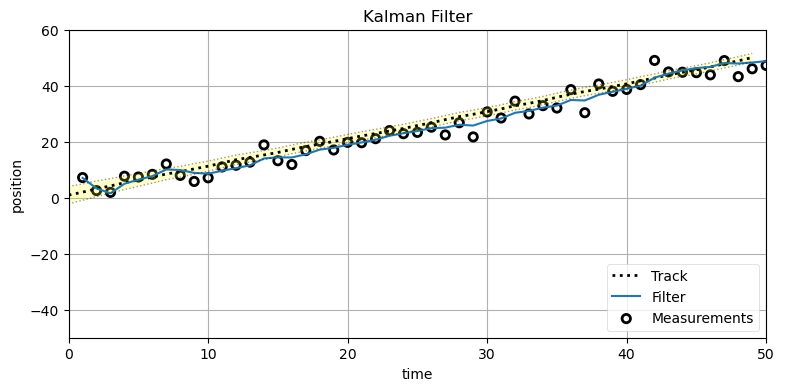

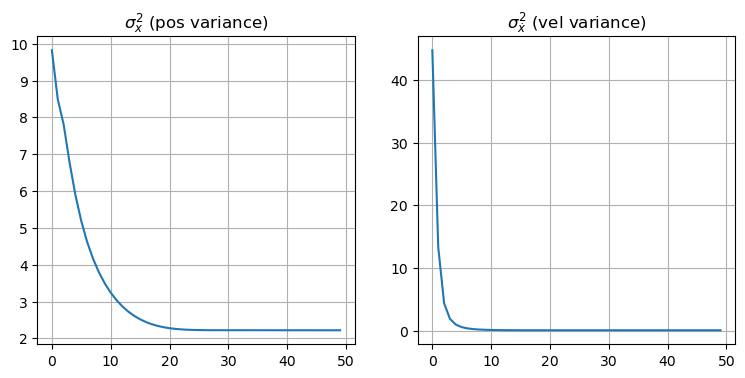

In [31]:
P = np.diag([500., 49.])
Ms, Ps = run(count=50, R=10, Q=0.01, P=P)

### Exercise 2: not using FilterPy (4 points)

FilterPy hides the details of the implementation from us. Normally you will appreciate this, but let's implement the last filter without FilterPy. To do so we need to define our matrices as variables, and then implement the Kalman filter equations explicitly.

Fill the code below, compare outputs with filterpy, once again play with parameters.

In [39]:
dt = 1.
R_var = # TODO
Q_var = # TODO
x = # TODO
P = # TODO
F = # TODO
H = # TODO
R = # TODO
Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_var)

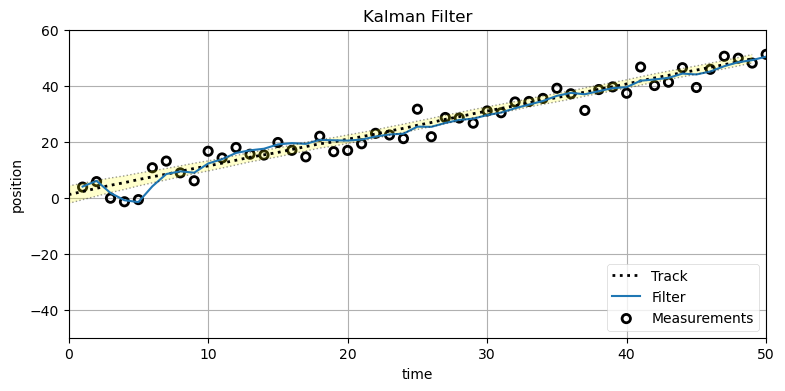

In [40]:
from scipy.linalg import inv

count = 50
track, zs = compute_dog_data(R_var, Q_var, count)
xs, cov = [], []
for z in zs:
    # predict
    x = # TODO
    P = # TODO
    
    #update
    S = # TODO
    K = # TODO
    y = # TODO
    x += # TODO
    P = # TODO
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)
#plot_track(xs[:, 0], track, zs, cov, plot_P=False)

## Exercise 3: Show Effect of Hidden Variables (3 points)

In our filter velocity is a hidden variable. How would a filter perform if we did not use velocity in the state?

Write a Kalman filter that uses the state $\mathbf x=\begin{bmatrix}x\end{bmatrix}$ and compare it against a filter that uses $\mathbf x=\begin{bmatrix}x & \dot x\end{bmatrix}^\mathsf T$.